# Using the BucketingProcess

The `BucketingProcess` enables a two-step bucketing approach, where a feature is first pre-bucketed to e.g. 100 pre-buckets, and then bucketed. 

This is a common practice - it reduces the complexity of finding exact boundaries to the problem of finding which of 100 buckets to merge together.

## Define the BucketingProcess

The bucketing process incorporates a pre-bucketing pipeline and a bucketing pipeline. You can also pass `specials` or `variables` and `BucketingProcess` will pass those settings on to the bucketers in the pipelines.

In the example below, we prebucket numerical features to max 100 bins, and prebucket categorical columns as-is (each unique value is a category and new categories end up in the other bucket).

In [1]:
from skorecard import datasets
from skorecard.bucketers import DecisionTreeBucketer, OptimalBucketer, AsIsCategoricalBucketer
from skorecard.pipeline import BucketingProcess

from sklearn.pipeline import make_pipeline

df = datasets.load_uci_credit_card(as_frame=True)
y = df["default"]
X = df.drop(columns=["default"])

num_cols = ["LIMIT_BAL", "BILL_AMT1"]
cat_cols = ["EDUCATION", "MARRIAGE"]
specials = {"EDUCATION": {"Is 1": [1]}}

bucketing_process = BucketingProcess(
    prebucketing_pipeline=make_pipeline(
        DecisionTreeBucketer(variables=num_cols, max_n_bins=100, min_bin_size=0.05),
        AsIsCategoricalBucketer(variables=cat_cols),
    ),
    bucketing_pipeline=make_pipeline(
        OptimalBucketer(variables=num_cols, max_n_bins=10, min_bin_size=0.05),
        OptimalBucketer(variables=cat_cols, variables_type="categorical", max_n_bins=10, min_bin_size=0.05),
    ),
    specials=specials,
)

bucketing_process.fit_transform(X, y).head()

EDUCATION  MARRIAGE  LIMIT_BAL  BILL_AMT1
0         -3         0          8          5
1          1         0          3          4
2         -3         0          8          5
3         -3         1          4          0
4          1         1          8          3

## Methods and Attributes

A `BucketingProcess` instance has all the similar methods & attributes of a bucketer:

- `.summary()`
- `.bucket_table(column)`
- `.plot_bucket(column)`
- `.features_bucket_mapping`
- `.save_to_yaml()`
- `.fit_interactive()`

but also adds a few unique ones:

- `.prebucket_table(column)`
- `.plot_prebucket(column)`


In [2]:
bucketing_process.summary()

column num_prebuckets num_buckets  IV_score    dtype
0  EDUCATION              9           5  0.036308    int64
1   MARRIAGE              6           4  0.013054    int64
2  LIMIT_BAL             14          10  0.168862  float64
3  BILL_AMT1             15           7  0.005823  float64

In [3]:
bucketing_process.prebucket_table("MARRIAGE")

pre-bucket    label   Count  Count (%)  Non-event  Event  Event Rate  \
0          -2    Other     0.0       0.00        0.0    0.0         NaN   
1          -1  Missing     0.0       0.00        0.0    0.0         NaN   
2           0        2  3138.0      52.30     2493.0  645.0    0.205545   
3           1        1  2784.0      46.40     2108.0  676.0    0.242816   
4           2        3    64.0       1.07       42.0   22.0    0.343750   
5           3        0    14.0       0.23       12.0    2.0    0.142857   

     WoE     IV  bucket  
0  0.000  0.000      -2  
1  0.000  0.000      -1  
2  0.110  0.006       0  
3 -0.104  0.005       1  
4 -0.594  0.004       1  
5  0.547  0.001       0

In [4]:
bucketing_process.bucket_table("MARRIAGE")

bucket    label   Count  Count (%)  Non-event  Event  Event Rate    WoE  \
0      -2    Other     0.0       0.00        0.0    0.0         NaN  0.000   
1      -1  Missing     0.0       0.00        0.0    0.0         NaN  0.000   
2       0     0, 3  3152.0      52.53     2505.0  647.0    0.205266  0.112   
3       1     1, 2  2848.0      47.47     2150.0  698.0    0.245084 -0.117   

      IV  
0  0.000  
1  0.000  
2  0.006  
3  0.007

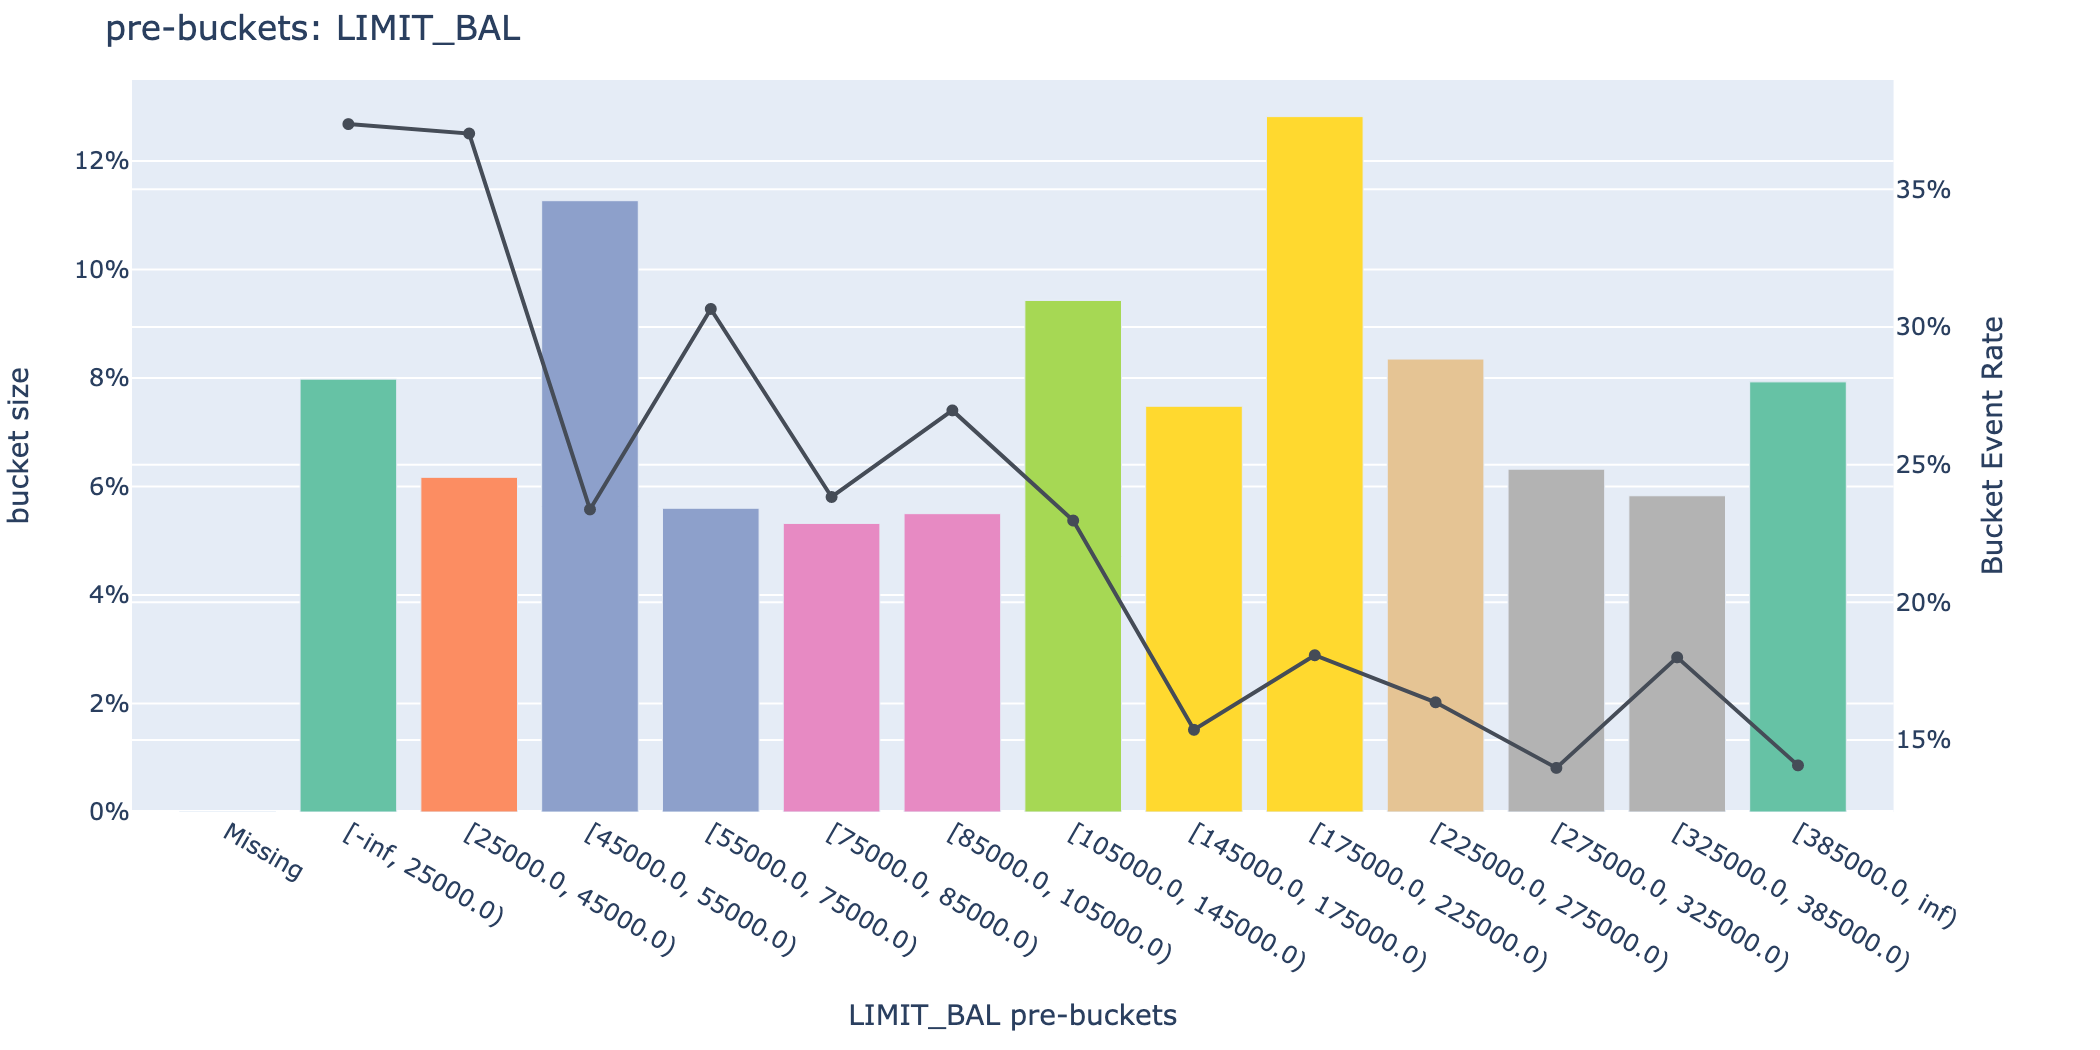

In [5]:
bucketing_process.plot_prebucket("LIMIT_BAL", format="png", scale=2, width=1050, height=525)

## The `.features_bucket_mapping` attribute

All skorecard bucketing classes have a `.features_bucket_mapping` attribute to access the stored bucketing information to go from an input feature to a bucketed feature. In the case of `BucketingProcess`, because there is a prebucketing and bucketing step, this means the bucket mapping reflects the net effect of merging both steps into one. This is demonstrated below:

In [6]:
bucketing_process.pre_pipeline_.features_bucket_mapping_.get("MARRIAGE").labels

{3: '0', 1: '1', 0: '2', 2: '3', -1: 'Missing', -2: 'Other'}

In [7]:
bucketing_process.pipeline_.features_bucket_mapping_.get("EDUCATION")

BucketMapping(feature_name='EDUCATION', type='categorical', missing_bucket=None, other_bucket=None, map={1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 0: 1}, right=False, specials={'Is 1': [-3]})

In [8]:
bucketing_process.features_bucket_mapping_.get("EDUCATION")

BucketMapping(feature_name='EDUCATION', type='categorical', missing_bucket=None, other_bucket=None, map={0: 0, 3: 0, 4: 0, 5: 0, 6: 0, 2: 1}, right=True, specials={'Is 1': [1]})

## The `.fit_interactive()` method

All skorecard bucketing classes have a `.fit_interactive()` method. In the case of `BucketingProcess` this will launch a slightly different app that shows the pre-buckets and the buckets, and allows you to edit the prebucketing as well.

In [9]:
# bucketing_process.fit_interactive(X, y) # not run